In [1]:
%matplotlib inline

# 1) Wipe out your namespace
%reset -f

# 2) Clear Jupyter’s stored outputs (and inputs if you like)
try:
    Out.clear() 
except NameError:
    pass

try:
    In.clear()
except NameError:
    pass

# 3) Force Python GC
import gc
gc.collect()

# 4) Free any GPU buffers
import torch
if torch.cuda.is_available():
    torch.cuda.empty_cache()


import importlib
from libs import preps, plots, params, feats
importlib.reload(preps)
importlib.reload(plots)
importlib.reload(params)
importlib.reload(feats)

<module 'libs.feats' from '/workspace/my_models/Trading/_Stock_Analysis_/libs/feats.py'>

In [2]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)

import matplotlib.pyplot as plt
import seaborn as sns

import glob
import os
import json
import re
import os
import psutil

import time
import datetime as dt
from datetime import timedelta

from tqdm.auto import tqdm
from IPython.display import clear_output, display

[process_splits] Loading original alpaca csv
Plotting original data...


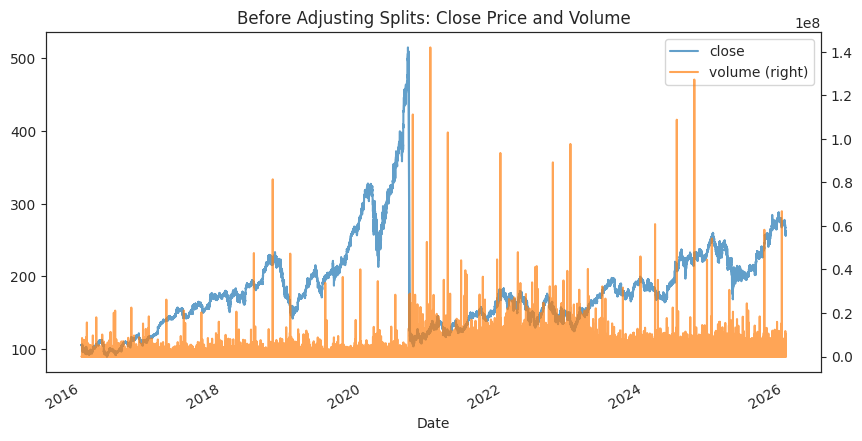

Executing [detect_and_adjust_splits]...
Detected forward split on 2020-08-31 08:00:00 with factor 4 (ratio: 0.2514)
Splits detected. Plotting adjusted data...


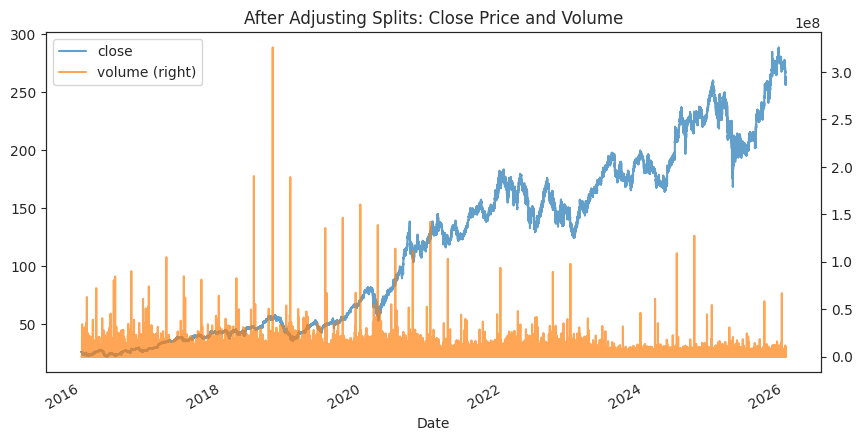

['executing prepare_interpolate_data']
normalize data...
prepare_interpolate_data: dropping 860 exact duplicate rows at: 2016-01-05 23:00:00, 2016-01-06 23:00:00, 2016-01-07 23:00:00, 2016-01-12 23:00:00, 2016-01-13 23:00:00, 2016-01-20 23:00:00, 2016-01-26 23:00:00, 2016-01-27 23:00:00, 2016-01-28 23:00:00, 2016-02-04 23:00:00, 2016-02-08 23:00:00, 2016-02-09 23:00:00, 2016-02-10 23:00:00, 2016-02-16 23:00:00, 2016-02-18 23:00:00, 2016-02-23 23:00:00, 2016-02-24 23:00:00, 2016-02-25 23:00:00, 2016-02-29 23:00:00, 2016-03-02 23:00:00, 2016-03-03 23:00:00, 2016-11-07 23:00:00, 2016-11-17 23:00:00, 2016-11-28 23:00:00, 2016-12-05 23:00:00, 2016-12-13 23:00:00, 2017-01-31 23:00:00, 2017-02-07 23:00:00, 2017-02-09 23:00:00, 2017-03-01 23:00:00, 2017-11-06 23:00:00, 2017-11-07 23:00:00, 2017-11-08 23:00:00, 2017-11-13 23:00:00, 2017-11-21 23:00:00, 2017-11-29 23:00:00, 2017-12-04 23:00:00, 2017-12-07 23:00:00, 2017-12-18 23:00:00, 2017-12-20 23:00:00, 2017-12-26 23:00:00, 2017-12-28 23:00:0

Saving CSV: 100%|██████████| 2355804/2355804 [00:28<00:00, 81978.74rows/s, size=221.5MB] 


,open,high,low,close,volume,trade_count,vwap,ask,bid
2015-12-31 23:00,26.3575,26.3575,26.3575,26.3575,700.000000,1.0,105.430000,26.362775,26.352225
2015-12-31 23:01,26.3500,26.3500,26.3500,26.3500,2020.000000,5.0,105.400000,26.355275,26.344725
2015-12-31 23:02,26.3500,26.3500,26.3500,26.3500,1593.333333,4.0,105.400000,26.355275,26.344725
2015-12-31 23:03,26.3500,26.3500,26.3500,26.3500,1166.666667,3.0,105.400000,26.355275,26.344725
2015-12-31 23:04,26.3500,26.3500,26.3500,26.3500,740.000000,2.0,105.400000,26.355275,26.344725
...,...,...,...,...,...,...,...,...,...
2026-01-09 17:29,259.0570,259.1500,259.0300,259.1200,60325.000000,1107.0,259.097549,259.171800,259.068200
2026-01-09 17:30,259.1300,259.2400,259.0700,259.0900,57175.000000,1244.0,259.172214,259.141800,259.038200
2026-01-09 17:31,259.0900,259.1500,259.0550,259.1000,65329.000000,1462.0,259.106580,259.151800,259.048200
2026-01-09 17:32,259.1000,259.1100,259.0100,259.0590,41561.000000,1097.0,259.064782,259.110800,259.007200


In [3]:
# cleaning and preparing the data to create the base_csv

df = preps.process_splits(
    ticker = params.ticker,
)

df = preps.prepare_interpolate_data(
    df = df
)

df.index = df.index.floor('min').strftime('%Y-%m-%d %H:%M') # cleaning the index

params.to_csv_with_progress(df, params.base_csv)
df

In [4]:
# adding trading indicators

df_inds_unsc = feats.standard_indicators(
    df,
    sma=[5, 9, 21, 50, 100, 200],
    ema=[3, 5, 8, 9, 13, 21, 50],
    atr=[7, 14, 28],
    bb={20: [2.0, 3.0], 50: [2.0]},  # or just [20, 50] for default dev=2.0
    rsi=[6, 14, 21],
    roc=[5, 10, 21],
    vol_spike=[7, 14, 28],
    obv_roll=[7, 21],
    ret_std=[21, 63],
    macd=[
        {"fast": 6, "slow": 13, "signal": 5},
        {"fast": 12, "slow": 26, "signal": 9},
    ],
    stoch=[
        {"k": 14, "d": 3, "smooth": 3},
        {"k": 9, "d": 3, "smooth": 3},
    ],
    cci=[14, 20],
    mfi=[14, 20],
    cmf=[14, 20],
    donch=[20, 55],
    roll_vwap=[20, 50],
    linreg_slope=[20, 50],
    kc=[
        {"ema_window": 20, "atr_window": 20, "atr_mult": 1.5},
        {"ema_window": 20, "atr_window": 20, "atr_mult": 2.0},
    ],
    psar={"step": 0.02, "max_step": 0.2},
)

df_inds_unsc


Indicators:   0%|          | 0/55 [00:00<?, ?task/s]

/usr/local/lib/python3.12/dist-packages/ta/trend.py:1030: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  self._psar[i] = high2


,open,high,low,close,volume,trade_count,vwap,ask,bid,ret,log_ret,sma_5,sma_pct_5,sma_9,sma_pct_9,sma_21,sma_pct_21,sma_50,sma_pct_50,sma_100,sma_pct_100,sma_200,sma_pct_200,ema_3,ema_5,ema_8,ema_9,ema_13,ema_21,ema_50,roc_5,roc_10,roc_21,body,body_pct,upper_shad,lower_shad,range_pct,rsi_6,rsi_14,rsi_21,macd_line_6_13_5,macd_signal_6_13_5,macd_diff_6_13_5,macd_line_12_26_9,macd_signal_12_26_9,macd_diff_12_26_9,atr_7,atr_pct_7,atr_14,atr_pct_14,atr_28,atr_pct_28,plus_di_7,minus_di_7,adx_7,plus_di_14,minus_di_14,adx_14,plus_di_28,minus_di_28,adx_28,bb_lband_20_2p0,bb_hband_20_2p0,bb_w_20_2p0,bb_lband_20_3p0,bb_hband_20_3p0,bb_w_20_3p0,bb_lband_50_2p0,bb_hband_50_2p0,bb_w_50_2p0,obv,vol_spike_7,vol_spike_14,vol_spike_28,rolling_max_close_200,rolling_min_close_200,dist_high_200,dist_low_200,obv_diff_7,obv_pct_7,obv_diff_21,obv_pct_21,ret_std_21,ret_std_63,stoch_k_14_3_3,stoch_d_14_3_3,stoch_k_9_3_3,stoch_d_9_3_3,cci_14,cci_20,mfi_14,mfi_20,cmf_14,cmf_20,donch_h_20,donch_l_20,donch_w_20,donch_h_55,donch_l_55,donch_w_55,roll_vwap_20,roll_vwap_50,slope_close_20,slope_close_50,kc_mid_20_20_1.5,kc_l_20_20_1.5,kc_h_20_20_1.5,kc_w_20_20_1.5,kc_mid_20_20_2.0,kc_l_20_20_2.0,kc_h_20_20_2.0,kc_w_20_20_2.0,psar,vwap_ohlc_close_session
2015-12-31 23:00:00,26.3575,26.3575,26.3575,26.3575,700.000000,1.0,105.430000,26.362775,26.352225,NaN,NaN,26.357500,0.000000,26.357500,0.000000,26.357500,0.000000,26.357500,0.000000,26.357500,0.000000,26.357500,0.000000,26.357500,26.357500,26.357500,26.357500,26.357500,26.357500,26.357500,NaN,NaN,NaN,0.000,0.000000,0.0000,0.000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.000000e+02,7.000000e+11,7.000000e+11,7.000000e+11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,50.000000,50.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26.357500,26.357500,NaN,NaN,26.357500,26.357500,26.357500,0.000000,26.357500,26.357500,26.357500,0.000000,26.357500,26.357500
2015-12-31 23:01:00,26.3500,26.3500,26.3500,26.3500,2020.000000,5.0,105.400000,26.355275,26.344725,-0.000285,-0.000285,26.353750,-0.000142,26.353750,-0.000142,26.353750,-0.000142,26.353750,-0.000142,26.353750,-0.000142,26.353750,-0.000142,26.353750,26.355000,26.355833,26.356000,26.356429,26.356818,26.357206,NaN,NaN,NaN,0.000,0.000000,0.0000,0.000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.320000e+03,2.020000e+12,2.020000e+12,2.020000e+12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,50.000000,50.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26.351930,26.351930,NaN,NaN,26.356786,26.356786,26.356786,0.000000,26.356786,26.356786,26.356786,0.000000,26.350000,26.351930
2015-12-31 23:02:00,26.3500,26.3500,26.3500,26.3500,1593.333333,4.0,105.400000,26.355275,26.344725,0.000000,0.000000,26.352500,-0.000095,26.352500,-0.000095,26.352500,-0.000095,26.352500,-0.000095,26.352500,-0.000095,26.352500,-0.000095,26.351875,26.353333,26.354537,26.354800,26.355510,26.356198,26.356923,NaN,NaN,NaN,0.000,0.000000,0.0000,0.000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.733333e+02,1.593333e+12,1.593333e+12,1.593333e+12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,50.000000,50.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26.351217,26.351217,NaN,NaN,26.356139,26.356139,26.356139,0.000000,26.356139,26.356139,26.356139,0.000000,26.357500,26.351217
2015-12-31 23:03:00,26.3500,26.3500,26.3500,26.3500,1166.666667,3.0,105.400000,26.355275,26.344725,0.000000,0.00000

In [5]:
params.to_csv_with_progress(df=df_inds_unsc, path=str(params.indunsc_csv))

Saving CSV: 100%|██████████| 2355804/2355804 [06:12<00:00, 6321.09rows/s, size=4.5GB] 


In [6]:
importlib.reload(feats) ############

df_inds_flag, diag = feats.flag_indicators(
    df = df_inds_unsc,
    train_prop = params.train_prop,
    pct_shift_thresh = 0.16,    # relative median shift threshold
    frac_outside_thresh = 0.06, # fraction outside 1–99% train range
    min_train_samples = 50,
    na_rate_thresh = 0.4,        # flag if >40% NaN in train or overall
    const_tol = 1e-12,
)

diag


Flagging indicators:   0%|          | 0/115 [00:00<?, ?feat/s]

Marking DRIFT columns:   0%|          | 0/55 [00:00<?, ?feat/s]

,feature,status,reason,pct_shift_val,pct_shift_te,frac_val_out,frac_te_out,na_rate_train,na_rate_all
0,open,DRIFT,"pct_shift_val=2.281,te=3.173; frac_out_val=0.6...",2.280875,3.173480,0.600958,0.998291,0.0,0.0
1,high,DRIFT,"pct_shift_val=2.281,te=3.173; frac_out_val=0.6...",2.280700,3.172989,0.600672,0.998356,0.0,0.0
2,low,DRIFT,"pct_shift_val=2.281,te=3.174; frac_out_val=0.6...",2.280916,3.173659,0.601226,0.998237,0.0,0.0
3,close,DRIFT,"pct_shift_val=2.281,te=3.173; frac_out_val=0.6...",2.280800,3.173405,0.601051,0.998305,0.0,0.0
4,volume,OK,,0.007038,0.007917,0.045355,0.056875,0.0,0.0
...,...,...,...,...,...,...,...,...,...
110,kc_l_20_20_2.0,DRIFT,"pct_shift_val=2.281,te=3.174; frac_out_val=0.6...",2.281349,3.174193,0.602234,0.998019,0.0,0.0
111,kc_h_20_20_2.0,DRIFT,"pct_shift_val=2.280,te=3.172; frac_out_val=0.6...",2.279965,3.171770,0.599919,0.998444,0.0,0.0
112,kc_w_20_20_2.0,OK,,0.044819,0.035172,0.004935,0.012740,0.0,0.0
113,psar,DRIFT,"pct_shift_val=2.281,te=3.174; frac_out_val=0.6...",2.281165,3.173582,0.600720,0.998245,0.0,0.0


In [7]:
# importlib.reload(feats) ############

df_inds_flag[[f"{c}_raw" for c in params.strategy_cols_tick]] = df_inds_unsc[params.strategy_cols_tick]

df_inds_rz = feats.apply_rz_to_drifts(
    df = df_inds_flag,
    diag = diag,
    rz_window = 60,        # default for 1m scalping; tune later
    min_periods = None,    # will default to rz_window//3 inside the function
    eps = 1e-6
)

df_inds_rz

Applying RZ to DRIFTs:   0%|          | 0/55 [00:00<?, ?feat/s]

,volume,trade_count,ret,log_ret,sma_pct_5,sma_pct_9,sma_pct_21,sma_pct_50,sma_pct_100,sma_pct_200,roc_5,roc_10,roc_21,body_pct,upper_shad,lower_shad,range_pct,rsi_6,rsi_14,rsi_21,atr_pct_7,atr_pct_14,atr_pct_28,plus_di_7,minus_di_7,adx_7,plus_di_14,minus_di_14,adx_14,plus_di_28,minus_di_28,adx_28,bb_w_20_2p0,bb_w_20_3p0,bb_w_50_2p0,vol_spike_7,vol_spike_14,vol_spike_28,dist_high_200,dist_low_200,obv_diff_7,obv_pct_7,obv_diff_21,obv_pct_21,ret_std_21,ret_std_63,stoch_k_14_3_3,stoch_d_14_3_3,stoch_k_9_3_3,stoch_d_9_3_3,cci_14,cci_20,mfi_14,mfi_20,cmf_14,cmf_20,donch_w_20,donch_w_55,kc_w_20_20_1.5,kc_w_20_20_2.0,close_raw,atr_14_raw,adx_14_raw,rsi_6_raw,vwap_ohlc_close_session_raw,vwap_RZ,sma_5_RZ,sma_9_RZ,sma_21_RZ,sma_50_RZ,sma_100_RZ,sma_200_RZ,ema_3_RZ,ema_5_RZ,ema_8_RZ,ema_9_RZ,ema_13_RZ,ema_21_RZ,ema_50_RZ,macd_line_6_13_5_RZ,macd_signal_6_13_5_RZ,macd_diff_6_13_5_RZ,macd_line_12_26_9_RZ,macd_signal_12_26_9_RZ,macd_diff_12_26_9_RZ,atr_7_RZ,atr_14_RZ,atr_28_RZ,rolling_max_close_200_RZ,rolling_min_close_200_RZ,roll_vwap_20_RZ,roll_vwap_50_RZ,slope_close_20_RZ,slope_close_50_RZ,psar_RZ,vwap_ohlc_close_session_RZ
2015-12-31 23:00:00,700.000000,1.0,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,0.000000,0.0000,0.000,0.000000,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,7.000000e+11,7.000000e+11,7.000000e+11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,50.000000,50.000000,NaN,NaN,NaN,NaN,0.000000,0.000000,26.3575,0.000000,0.000000,NaN,26.357500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-12-31 23:01:00,2020.000000,5.0,-0.000285,-0.000285,-0.000142,-0.000142,-0.000142,-0.000142,-0.000142,-0.000142,NaN,NaN,NaN,0.000000,0.0000,0.000,0.000000,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,2.020000e+12,2.020000e+12,2.020000e+12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,50.000000,50.000000,NaN,NaN,NaN,NaN,0.000000,0.000000,26.3500,0.000000,0.000000,NaN,26.351930,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-12-31 23:02:00,1593.333333,4.0,0.000000,0.000000,-0.000095,-0.000095,-0.000095,-0.000095,-0.000095,-0.000095,NaN,NaN,NaN,0.000000,0.0000,0.000,0.000000,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,1.593333e+12,1.593333e+12,1.593333e+12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,50.000000,50.000000,NaN,NaN,NaN,NaN,0.000000,0.000000,26.3500,0.000000,0.000000,NaN,26.351217,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-12-31 23:03:00,1166.666667,3.0,0.000000,0.000000,-0.000071,-0.000071,-0.000071,-0.000071,-0.000071,-0.000071,NaN,NaN,NaN,0.000000,0.0000,0.000,0.000000,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,1.166667e+12,1.166667e+12,1.166667e+12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,50.000000,50.000000,NaN,NaN,NaN,NaN,0.000000,0.000000,26.3500,0.000000,0.000000,NaN,26.350958,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-12-31 23:04:00,740.000000,2.0,0.000000,0.000000,-0.000057,-0.000057,-0.000057,-0.000057,-0.000057,-0.000057,NaN,NaN,NaN,0.000000,0.0000,0.000,0.000000,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,7.400000e+11,7.400000e+11,7.400000e+11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Na

In [8]:
df.index = pd.to_datetime(df.index).floor('min')
df_time = feats.add_session_centered_time_features(df)
df_time

,time_minute,time_hour,time_dow,time_month,time_day_of_year,time_week_of_year,time_in_sess,time_premark,time_afthour
2015-12-31 23:00:00,0.895833,0.895833,0.928571,0.416667,0.497260,0.500000,0.0,0.0,1.0
2015-12-31 23:01:00,0.896528,0.895833,0.928571,0.416667,0.497260,0.500000,0.0,0.0,1.0
2015-12-31 23:02:00,0.897222,0.895833,0.928571,0.416667,0.497260,0.500000,0.0,0.0,1.0
2015-12-31 23:03:00,0.897917,0.895833,0.928571,0.416667,0.497260,0.500000,0.0,0.0,1.0
2015-12-31 23:04:00,0.898611,0.895833,0.928571,0.416667,0.497260,0.500000,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...
2026-01-09 17:29:00,0.665972,0.645833,0.071429,0.500000,0.521918,0.519231,1.0,0.0,0.0
2026-01-09 17:30:00,0.666667,0.645833,0.071429,0.500000,0.521918,0.519231,1.0,0.0,0.0
2026-01-09 17:31:00,0.667361,0.645833,0.071429,0.500000,0.521918,0.519231,1.0,0.0,0.0
2026-01-09 17:32:00,0.668056,0.645833,0.071429,0.500000,0.521918,0.519231,1.0,0.0,0.0


In [9]:
# importlib.reload(feats) ############

df_feat_scal, stats = feats.scale_features(
    df=df_inds_rz,
    train_prop=params.train_prop,   # same split for flagging
    p_lo=1.0,         # train p1
    p_hi=99.0,        # train p99
    eps=1e-6,
    include_rz=True  # keep *_RZ as-is; set True to scale them too
)
stats

MinMax p1/p99:   0%|          | 0/91 [00:00<?, ?feat/s]

,min,max
feature,,
volume,261.000000,1.109125e+06
trade_count,1.000000,3.923000e+03
ret,-0.001749,1.745121e-03
log_ret,-0.001750,1.743600e-03
sma_pct_5,-0.001919,1.910410e-03
...,...,...
roll_vwap_50_RZ,-9.358614,1.007067e+01
slope_close_20_RZ,-8.579068,9.104410e+00
slope_close_50_RZ,-8.082869,8.567726e+00


In [10]:
df_feat_scal = pd.concat([df_feat_scal, df_time], axis=1)
df_feat_scal

,volume,trade_count,ret,log_ret,sma_pct_5,sma_pct_9,sma_pct_21,sma_pct_50,sma_pct_100,sma_pct_200,roc_5,roc_10,roc_21,body_pct,upper_shad,lower_shad,range_pct,rsi_6,rsi_14,rsi_21,atr_pct_7,atr_pct_14,atr_pct_28,plus_di_7,minus_di_7,adx_7,plus_di_14,minus_di_14,adx_14,plus_di_28,minus_di_28,adx_28,bb_w_20_2p0,bb_w_20_3p0,bb_w_50_2p0,vol_spike_7,vol_spike_14,vol_spike_28,dist_high_200,dist_low_200,obv_diff_7,obv_pct_7,obv_diff_21,obv_pct_21,ret_std_21,ret_std_63,stoch_k_14_3_3,stoch_d_14_3_3,stoch_k_9_3_3,stoch_d_9_3_3,cci_14,cci_20,mfi_14,mfi_20,cmf_14,cmf_20,donch_w_20,donch_w_55,kc_w_20_20_1.5,kc_w_20_20_2.0,close_raw,atr_14_raw,adx_14_raw,rsi_6_raw,vwap_ohlc_close_session_raw,vwap_RZ,sma_5_RZ,sma_9_RZ,sma_21_RZ,sma_50_RZ,sma_100_RZ,sma_200_RZ,ema_3_RZ,ema_5_RZ,ema_8_RZ,ema_9_RZ,ema_13_RZ,ema_21_RZ,ema_50_RZ,macd_line_6_13_5_RZ,macd_signal_6_13_5_RZ,macd_diff_6_13_5_RZ,macd_line_12_26_9_RZ,macd_signal_12_26_9_RZ,macd_diff_12_26_9_RZ,atr_7_RZ,atr_14_RZ,atr_28_RZ,rolling_max_close_200_RZ,rolling_min_close_200_RZ,roll_vwap_20_RZ,roll_vwap_50_RZ,slope_close_20_RZ,slope_close_50_RZ,psar_RZ,vwap_ohlc_close_session_RZ,time_minute,time_hour,time_dow,time_month,time_day_of_year,time_week_of_year,time_in_sess,time_premark,time_afthour
2015-12-31 23:00:00,0.000396,0.000000,NaN,NaN,0.501100,0.501252,0.503744,0.506768,0.510859,0.515380,NaN,NaN,NaN,0.502374,0.0000,0.000000,0.000000,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,1.000000,1.000000,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.499818,0.498705,0.500000,0.500000,NaN,NaN,NaN,NaN,0.000000,0.000000,26.3575,0.000000,0.000000,NaN,26.357500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.895833,0.895833,0.928571,0.416667,0.497260,0.500000,0.0,0.0,1.0
2015-12-31 23:01:00,0.001586,0.001020,0.419100,0.419525,0.463940,0.475557,0.487773,0.496842,0.503946,0.510473,NaN,NaN,NaN,0.502374,0.0000,0.000000,0.000000,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,1.000000,1.000000,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.499818,0.498705,0.500000,0.500000,NaN,NaN,NaN,NaN,0.000000,0.000000,26.3500,0.000000,0.000000,NaN,26.351930,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.896528,0.895833,0.928571,0.416667,0.497260,0.500000,0.0,0.0,1.0
2015-12-31 23:02:00,0.001202,0.000765,0.500539,0.500976,0.476326,0.484121,0.493096,0.500150,0.506250,0.512109,NaN,NaN,NaN,0.502374,0.0000,0.000000,0.000000,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,1.000000,1.000000,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.499818,0.498705,0.500000,0.500000,NaN,NaN,NaN,NaN,0.000000,0.000000,26.3500,0.000000,0.000000,NaN,26.351217,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.897222,0.895833,0.928571,0.416667,0.497260,0.500000,0.0,0.0,1.0
2015-12-31 23:03:00,0.000817,0.000510,0.500539,0.500976,0.482519,0.488403,0.495758,0.501804,0.507402,0.512927,NaN,NaN,NaN,0.502374,0.0000,0.000000,0.000000,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,1.000000,1.000000,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.499818,0.498705,0.500000,0.500000,NaN,NaN,NaN,NaN,0.000000,0.000000,26.3500,0.000000,0.000000,NaN,26.350958,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.897917,0.895833,0.928571,0.416667,0.497260,0.500000,0.0,0.0,1.0
2015-12-31 23:04:00,0.000432,0.0

Plotting features:   0%|          | 0/105 [00:00<?, ?it/s]

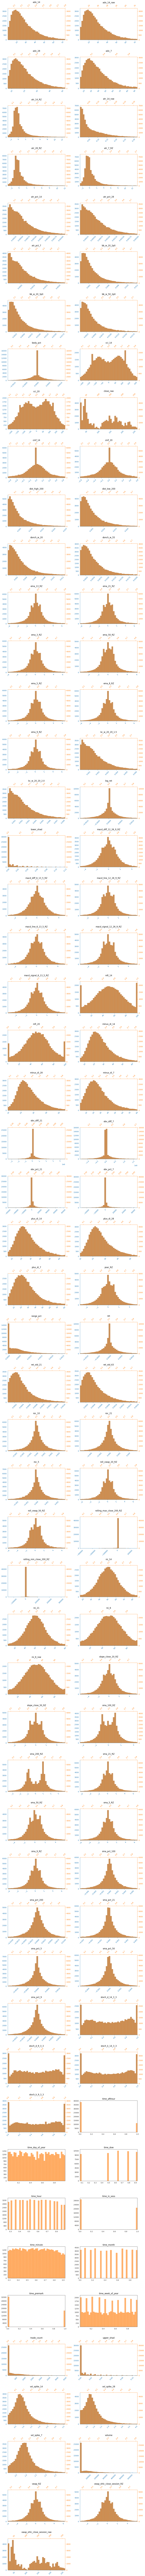

In [11]:
importlib.reload(plots)
plots.plot_dual_histograms(
    df_before = df_inds_rz,
    df_after  = df_feat_scal,
)

In [14]:
importlib.reload(plots) #######
importlib.reload(params) #######

# choose if to plot raw indicators or scaled features
df_month = df_feat_scal[df_feat_scal.index.to_period('M') == params.month_to_check].copy() # scaled features
# df_month = df_inds_unsc[df_inds_unsc.index.to_period('M') == params.month_to_check].copy() # unscaled indicators

for base_day, grp in df_month.groupby(df_month.index.normalize()):
    print('='*160)
    print(f"{base_day.date()}: rows={len(grp)}, start={grp.index.min()}, end={grp.index.max()}")
    plots.plot_trades(
        df=grp,
        col_close='close_raw',
        features=list(grp.columns),
    )


In [13]:
params.to_csv_with_progress(df = df_feat_scal, path = params.feat_all_csv)

Saving CSV: 100%|██████████| 2355804/2355804 [06:31<00:00, 6010.32rows/s, size=4.1GB] 
